In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [3]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0][1:]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1][:-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [4]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [5]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [6]:
df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])
df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])
df_smart_idx = np.concatenate([dffn.index, df2fn.index])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(0)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

df_MCF7_idx = [idx for idx in df_all.index if "MCF7" in idx]


In [7]:
df_all["mcf"] = ["MCF7" in idx for idx in df_all.index]
df_all["smart"] = [idx in df_smart_idx for idx in df_all.index]

In [8]:
df_all = df_all.astype(np.int32)

In [9]:
# Free up memory
del dffn, df2fn, df3, df4, dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx, df_meta, df2_meta

In [48]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class NNClassifier(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNClassifier, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [41]:
input_size = df_all.shape[1]
learning_rate = 1e-3
num_epochs = 100

hidden_size = 1024
hidden_size1 = 512
hidden_size2 = 256

test_amount = 0.2

In [33]:
df_train, df_test = train_test_split(df_all, test_size=test_amount)

In [34]:
dataset = NNDataset(df_train, df_all_norm_idx)
data_loader = DataLoader(dataset, batch_size=512, shuffle=True)

In [35]:
dataset_test = NNDataset(df_test, df_all_norm_idx)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

df_test_smart = df_test[[i in df_smart_idx for i in df_test.index]]
df_test_drop = df_test[[i not in df_smart_idx for i in df_test.index]]

dataset_test_smart = NNDataset(df_test_smart, df_smart_norm_idx)
dataset_test_drop = NNDataset(df_test_drop, df_drop_norm_idx)

test_loader_smart = DataLoader(dataset_test_smart, batch_size=64, shuffle=True)
test_loader_drop = DataLoader(dataset_test_drop, batch_size=64, shuffle=True)

In [49]:
# Define the model
model = NNClassifier(input_size, hidden_size, hidden_size1, hidden_size2).to(device)

In [50]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
model

NNClassifier(
  (layers): Sequential(
    (0): Linear(in_features=8647, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [52]:
train_config = [
    [200, data_loader]
]

In [53]:
# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in tqdm(data_loaderr):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs[:, 0], labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}")

  0%|          | 1/200 [00:04<13:47,  4.16s/it]

Epoch 1, Loss: 0.21318645329327032


  1%|          | 2/200 [00:08<13:35,  4.12s/it]

Epoch 2, Loss: 0.03362051034940046


  2%|▏         | 3/200 [00:12<13:26,  4.09s/it]

Epoch 3, Loss: 0.014044493340416839


  2%|▏         | 4/200 [00:16<13:12,  4.04s/it]

Epoch 4, Loss: 0.003823386614755989


  2%|▎         | 5/200 [00:20<12:58,  3.99s/it]

Epoch 5, Loss: 0.006410611082104784


  3%|▎         | 6/200 [00:24<12:50,  3.97s/it]

Epoch 6, Loss: 0.002946405914478099


  4%|▎         | 7/200 [00:28<12:44,  3.96s/it]

Epoch 7, Loss: 0.0002508058492610671


  4%|▍         | 8/200 [00:31<12:38,  3.95s/it]

Epoch 8, Loss: 0.003923533147600465


  4%|▍         | 9/200 [00:35<12:33,  3.95s/it]

Epoch 9, Loss: 0.001067026763667563


  5%|▌         | 10/200 [00:39<12:30,  3.95s/it]

Epoch 10, Loss: 0.002483721132154138


  6%|▌         | 11/200 [00:43<12:24,  3.94s/it]

Epoch 11, Loss: 0.014183232215034005


  6%|▌         | 12/200 [00:47<12:21,  3.95s/it]

Epoch 12, Loss: 0.005958693385976556


  6%|▋         | 13/200 [00:51<12:25,  3.99s/it]

Epoch 13, Loss: 0.02574185913450763


  7%|▋         | 14/200 [00:55<12:17,  3.96s/it]

Epoch 14, Loss: 0.015778917017760217


  8%|▊         | 15/200 [00:59<12:10,  3.95s/it]

Epoch 15, Loss: 0.0032922659253581386


  8%|▊         | 16/200 [01:03<12:07,  3.95s/it]

Epoch 16, Loss: 0.0008792735319960318


  8%|▊         | 17/200 [01:07<12:03,  3.95s/it]

Epoch 17, Loss: 0.00011873805429936954


  9%|▉         | 18/200 [01:11<12:05,  3.98s/it]

Epoch 18, Loss: 0.00013161879027508676


 10%|▉         | 19/200 [01:15<11:57,  3.97s/it]

Epoch 19, Loss: 1.2565504699268566e-05


 10%|█         | 20/200 [01:19<11:56,  3.98s/it]

Epoch 20, Loss: 1.075328626984612e-07


 10%|█         | 21/200 [01:23<11:48,  3.96s/it]

Epoch 21, Loss: 3.8764382184082794e-07


 11%|█         | 22/200 [01:27<11:40,  3.94s/it]

Epoch 22, Loss: 9.996061513720138e-07


 12%|█▏        | 23/200 [01:31<11:36,  3.93s/it]

Epoch 23, Loss: 9.948602808377523e-07


 12%|█▏        | 23/200 [01:34<12:09,  4.12s/it]


KeyboardInterrupt: 

In [55]:
@torch.no_grad
def measure_model(model, data_loader):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted +0.5 > labels).sum().item()
        y_pred_class.extend(predicted.cpu().round()) # Save Prediction
        y_pred.extend(predicted.cpu()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    print("F1 Score:", f1_score(y_true, y_pred_class))
    print("Recall:", recall_score(y_true, y_pred_class))
    print(f'Accuracy of the network on the {total} test images: {(correct / total) * 100}%')


F1 Score: 1.0
Recall: 1.0
Accuracy of the network on the 7348 test images: 100.0%


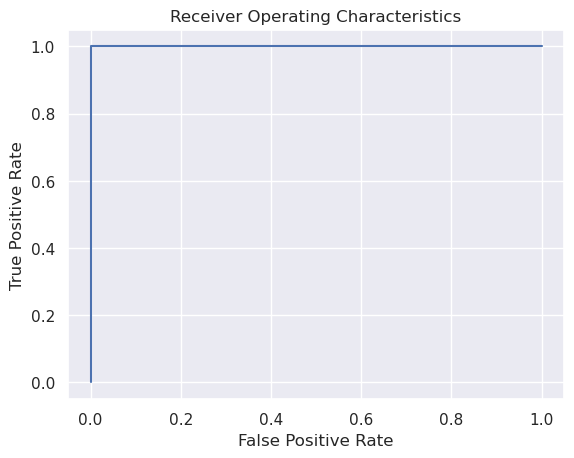

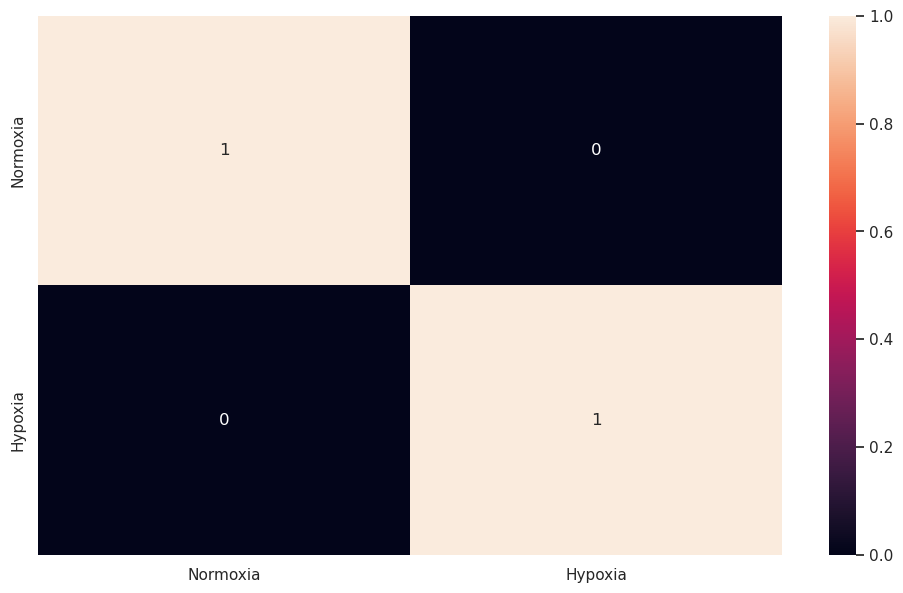

In [56]:
measure_model(model, test_loader)

F1 Score: 1.0
Recall: 1.0
Accuracy of the network on the 88 test images: 100.0%


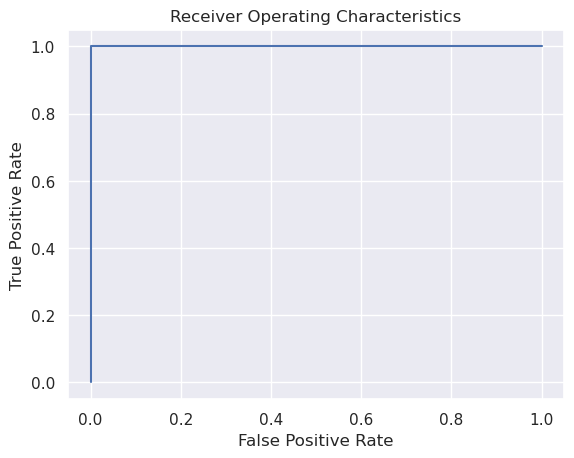

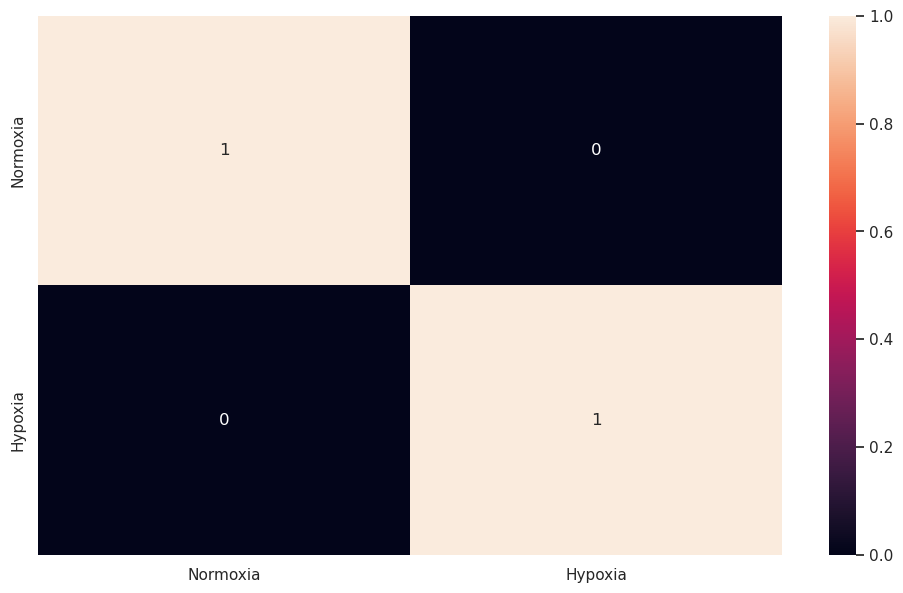

In [57]:
measure_model(model, test_loader_smart)

/usr/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

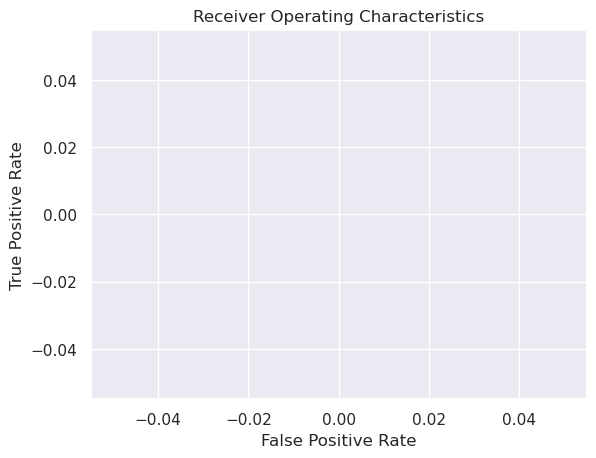

In [58]:

measure_model(model, test_loader_drop)